# Comparing the Compressible Solvers

Here we'll run the same problem (the single-mode Rayleigh-Taylor instability)
with 3 different compressible solvers.

In [1]:
from pyro import Pyro

We'll append the `Pyro` objects to the `runs` list as we do the simulations.

In [2]:
runs = []
solvers = ["compressible", "compressible_rk", "compressible_fv4"]

We'll override the default number of cells for the `rt` problem to make it smaller (and run faster).

In [3]:
problem = "rt"
params = {"mesh.nx": 32, "mesh.ny": 96, "driver.cfl": 0.8}

Now we loop over the solvers, setup the `Pyro` object and run the simulations.

In [4]:
for s in solvers:
    p = Pyro(s)
    p.initialize_problem(problem_name=problem, inputs_dict=params)
    p.run_sim()
    runs.append(p)

/home/zingale/development/pyro2/pyro/compressible/problems/rt.py:72: RuntimeWarning: invalid value encountered in divide
  0.5*(xmom[:, :]**2 + ymom[:, :]**2)/dens[:, :]
/home/zingale/development/pyro2/pyro/compressible_rk/problems/rt.py:72: RuntimeWarning: invalid value encountered in divide
  0.5*(xmom[:, :]**2 + ymom[:, :]**2)/dens[:, :]
/home/zingale/development/pyro2/pyro/compressible_fv4/problems/rt.py:72: RuntimeWarning: invalid value encountered in divide
  0.5*(xmom[:, :]**2 + ymom[:, :]**2)/dens[:, :]


Finally, we'll plot them.  We'll just look at the density and put them all on the same set of axes.
Since our data is stored as $\rho(x, y)$, `imshow()` will want to put $x$ on the vertical axis, so
we transpose the data before plotting.

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

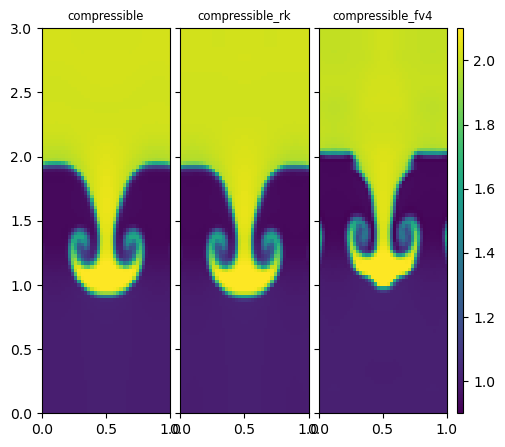

In [6]:
fig = plt.figure(figsize=(7, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(runs)), axes_pad=0.1,
                 share_all=True, cbar_mode="single", cbar_location="right")

for ax, s, p in zip(grid, solvers, runs):
    rho = p.get_var("density")
    g = p.get_grid()
    im = ax.imshow(rho.T,
                   extent=[g.xmin, g.xmax, g.ymin, g.ymax],
                   origin="lower", vmin=0.9, vmax=2.1)
    ax.set_title(s, fontsize="small")
grid.cbar_axes[0].colorbar(im)

We see that the 4th order solver has more structure at fine scales (this becomes even more apparently at higher resolutions).